In [1]:
println("Hello super people!")

Hello super people!


In [2]:
using Random, Plots, Statistics, Combinatorics, LaTeXStrings, CSV, DataFrames, StatsBase


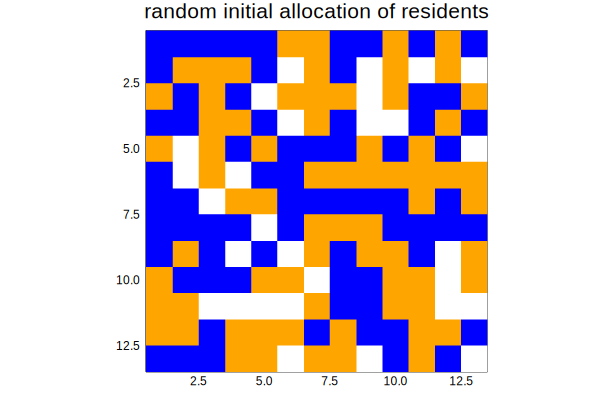

In [3]:

#define the grid
#schelling used originally 13x13 grid
GRID_SIZE = 13
CELL_COUNT = GRID_SIZE^2

THRESHOLD_SAME = 4
THRESHOLD_EDGE = 3
THRESHOLD_CORNER = 2

PP = 5

MM = 10#number of simulations
TT = 25#number of time points in simulation


yellow_count = Int(round(CELL_COUNT * PP/(GRID_SIZE-1)))
blue_count = Int(round(CELL_COUNT * PP/(GRID_SIZE-1)))
empty_count = CELL_COUNT - yellow_count - blue_count

#the total number of possible configurations
CELLS_SPACE_SIZE = multinomial(BigInt(yellow_count),BigInt(blue_count),BigInt(empty_count))
#println(CELLS_SPACE_SIZE)

#boltzmann constant
k_b = 1.380649*10^-23


empty_grid = zeros(GRID_SIZE,GRID_SIZE)
empty_grid[1:yellow_count] .= 1
empty_grid[yellow_count+1:yellow_count+blue_count] .= -1

start_grid = shuffle(empty_grid)

#random initial allocation heatmap viz
#yellow = -1, blue = 1
h = heatmap(start_grid,title="random initial allocation of residents",
    showaxis=true,xticks=true,yticks=true,yaxis=:flip,aspect_ratio=1.0,framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=nothing,
    c=ColorGradient([:orange,:white,:blue]))


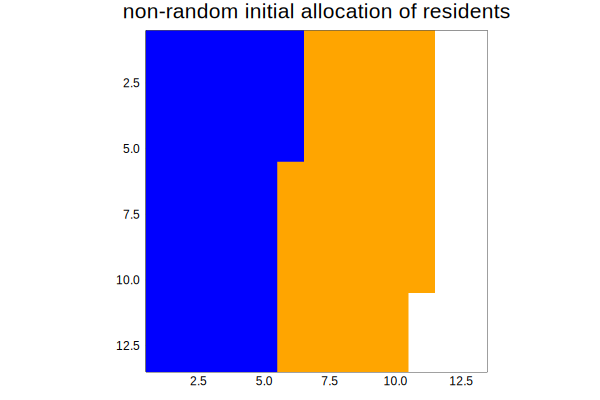

In [4]:
savefig(h,"figs/randomAllocationInit.png")

yellow_count = Int(round(CELL_COUNT * PP/(GRID_SIZE-1)))
blue_count = Int(round(CELL_COUNT * PP/(GRID_SIZE-1)))

empty_grid = zeros(GRID_SIZE,GRID_SIZE)
empty_grid[1:yellow_count] .= 1
empty_grid[yellow_count+1:yellow_count+blue_count] .= -1

set_grid = empty_grid#shuffle(empty_grid)

#random initial allocation heatmap viz
#yellow = -1, blue = 1
h2 = heatmap(set_grid,title="non-random initial allocation of residents",
    showaxis=true,xticks=true,yticks=true,yaxis=:flip,aspect_ratio=1.0,framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=nothing,
    c=ColorGradient([:orange,:white,:blue]))

In [5]:
savefig(h2,"figs/setAllocation.png")

#macrostate function mapping (eg, what is the total satisfaction of the residents overall the cells, total sum from zero to max)
#function overall_satisfaction(start_grid)

function grid_satisfaction(grid)
    cell_satisfaction = []

    for row in 1:GRID_SIZE
        for col in 1:GRID_SIZE
            
            t=cell_surround_arrayTMP(grid,row,col)  #R2 = R_grid(start_grid)
            tmpBinary = thresholdFN(t,grid[row,col],row,col)
            append!(cell_satisfaction,tmpBinary)
        end
    end
    return sum(cell_satisfaction)
end

function thresholdFN(cellSurroundArray,cellType,row,col)
    homogeneity = length(findall(cellType .== cellSurroundArray))
    #println(homogeneity)
    if(cellType != 0)
        if(!(row == 1 || row == GRID_SIZE || col == 1 || col == GRID_SIZE))#general inner body
            return homogeneity >= THRESHOLD_SAME ? 1 : 0
        elseif((row==GRID_SIZE && col==GRID_SIZE))#bottom right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0    
        elseif((row==1 && col==1))#top left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && col==GRID_SIZE))#top right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==GRID_SIZE && col==1))#bottom left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && (col < GRID_SIZE && col > 1) ))#top edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == 1) )#left edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == GRID_SIZE) )#right edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row == GRID_SIZE) && (col > 1 && col < GRID_SIZE) )#bottom edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        end
    else
        return 0
    end
end
function cell_surround_arrayTMP(grid,row,col)
    cell_surrounding = []
    for ii in 0:2
        for jj in 0:2
            if(!(  (ii==1 && jj==1) || (row-1+(ii) < 1) ||  (col-1+(jj) < 1) || (row-1+(ii) > GRID_SIZE) || (col-1+(jj) > GRID_SIZE)   ))
                append!(cell_surrounding,grid[row-1+(ii),(col-1)+(jj)])
            end

        end
    end

    return cell_surrounding
end

R_MAX = grid_satisfaction(set_grid)
println("set grid satisfaction value MAX=",R_MAX)
R_START = grid_satisfaction(start_grid)
println("set grid satisfaction value START=",R_START)


set grid satisfaction value MAX=140
set grid satisfaction value START=52


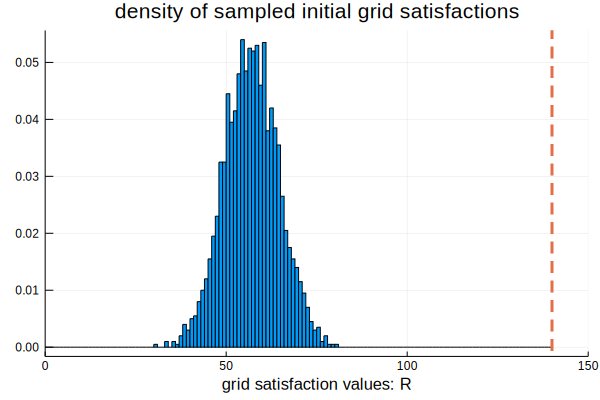

In [6]:
#sample the random intializations and investigate 
function make_random_grid()
    empty_grid = zeros(GRID_SIZE,GRID_SIZE)
    empty_grid[1:yellow_count] .= 1
    empty_grid[yellow_count+1:yellow_count+blue_count] .= -1
    random_grid = shuffle(empty_grid)
    return random_grid
end
numberOfRandomSamples = 2000
randomSatisfactions = [grid_satisfaction(make_random_grid()) for x in 1:numberOfRandomSamples]
normedRandomSatisfactions = randomSatisfactions ./ sum(randomSatisfactions)
pltHist = histogram(randomSatisfactions,bins=0:1:R_MAX,normalize=:probability,xlim=(0,R_MAX+10),title="density of sampled initial grid satisfactions",xlabel="grid satisfaction values: R")
vline!([R_MAX],line=(3,:dash),leg=false)

In [7]:
savefig(pltHist,"figs/histogramOfSampledInitSatisfactions.png")

#llok at not the grid level satisfaction but the single cell level satisfaction
function cell_surround_array(grid,row,col)
    #if((row==1 && col==1))#top left corner
    cell_surrounding = []
    for ii in 0:2
        for jj in 0:2
            if(!(  (ii==1 && jj==1) || (row-1+(ii) < 1) ||  (col-1+(jj) < 1) || (row-1+(ii) > GRID_SIZE) || (col-1+(jj) > GRID_SIZE)   ))
                append!(cell_surrounding,grid[row-1+(ii),(col-1)+(jj)])
            end

        end
    end
  
    return cell_surrounding
end

function is_cell_satisfied(grid,row,col)
    cellSurroundArray = cell_surround_array(grid,row,col)
    #println(cellSurroundArray)
    cellType = grid[row,col]
    #println(cellType)
    homogeneity = length(findall(cellType .== cellSurroundArray))
    #println(homogeneity)
    if(cellType != 0)
        if(!(row == 1 || row == GRID_SIZE || col == 1 || col == GRID_SIZE))#general inner body
            return homogeneity >= THRESHOLD_SAME ? 1 : 0
        elseif((row==GRID_SIZE && col==GRID_SIZE))#bottom right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0    
        elseif((row==1 && col==1))#top left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && col==GRID_SIZE))#top right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==GRID_SIZE && col==1))#bottom left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && (col < GRID_SIZE && col > 1) ))#top edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == 1) )#left edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == GRID_SIZE) )#right edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row == GRID_SIZE) && (col > 1 && col < GRID_SIZE) )#bottom edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        end
    else
        return 0
    end
end 

#cell_satisfied = is_cell_satisfied(start_grid,8,7)
#println(cell_satisfied)
 


is_cell_satisfied (generic function with 1 method)

In [8]:
#testing for if a cell would be satisfied if it were placed there
function would_cell_be_satisfied(grid,row,col,cellType)
    cellSurroundArray = cell_surround_array(grid,row,col)    
    #println(cellSurroundArray)
    homogeneity = length(findall(cellType .== cellSurroundArray))    
    #println(homogeneity)
    if(cellType != 0)
        if(!(row == 1 || row == GRID_SIZE || col == 1 || col == GRID_SIZE))#general inner body
            return homogeneity >= THRESHOLD_SAME ? 1 : 0
        elseif((row==GRID_SIZE && col==GRID_SIZE))#bottom right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0    
        elseif((row==1 && col==1))#top left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && col==GRID_SIZE))#top right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==GRID_SIZE && col==1))#bottom left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && (col < GRID_SIZE && col > 1) ))#top edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == 1) )#left edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == GRID_SIZE) )#right edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row == GRID_SIZE) && (col > 1 && col < GRID_SIZE) )#bottom edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        end
    else
        return 0
    end
end 

#cell_satisfied = would_cell_be_satisfied(start_grid,7,9,start_grid[2,2])
#println(cell_satisfied)
 

would_cell_be_satisfied (generic function with 1 method)

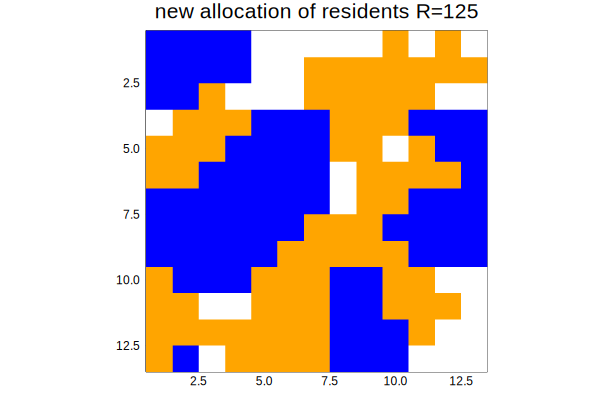

In [9]:
#get non-empty cell set
#Search for an unsatisfied iteratively in all the cells through a shuffled list
#find all empty cells
#shuffle the list of the empty cells
#see if the cell would_cell_be_satisfied in any of the cells in sequence
#no, move on to the next cell
#if yes, change the original cell position to empty and make the new cell the cell type
#loop till all non-empty cells are tested

function move_cells_for_satisfaction(grid)
    
    newGrid = deepcopy(grid)
    nonZeroCells = findall(grid .!= 0)
    nonZeroCells2 = shuffle(nonZeroCells)
    satisfiedNonZeroCells = [is_cell_satisfied(newGrid,nzc[1],nzc[2]) for nzc in nonZeroCells2]    
    #R_START = grid_satisfaction(grid)

    #remove (skip) the satisfied, don't include them in the rotation on each iteration
    satisfiedInds = findall(satisfiedNonZeroCells .== 1)
    deleteat!(nonZeroCells2,satisfiedInds)   
    
    for nzc in nonZeroCells2        
        isCellSatisfied = is_cell_satisfied(newGrid,nzc[1],nzc[2])
        
        if(isCellSatisfied != 1)          
            emptyCells = findall(newGrid .== 0)
            emptyCells2 = shuffle(emptyCells)
            #find an empty cell nzc could move to
            moved = false
            for ec in emptyCells2                
                wouldCellBeSatisfied = would_cell_be_satisfied(newGrid,ec[1],ec[2],newGrid[nzc[1],nzc[2]] )
                if(wouldCellBeSatisfied == 1)  
                    
                    newGrid[ec[1],ec[2]] = newGrid[nzc[1],nzc[2]]
                    newGrid[nzc[1],nzc[2]] = 0  
                    #no longer try to move it
                    moved = true
                    break
                end                
            end   
            #=if(moved == false)
                println("cell at i=$(nzc[1]) and j=$(nzc[2]) did not move")
            end=#
        end       
    end
    
    return newGrid
end

newGrid = move_cells_for_satisfaction(start_grid)

satisfiedOneGrid = grid_satisfaction(newGrid)
#println(satisfiedOneGrid)
h3 = heatmap(newGrid,title="new allocation of residents R=$(satisfiedOneGrid)",
    showaxis=true,xticks=true,yticks=true,yaxis=:flip,aspect_ratio=1.0,framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=nothing,
    c=ColorGradient([:orange,:white,:blue]))


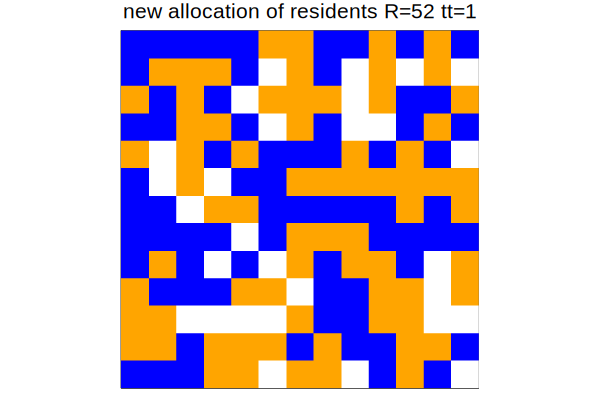

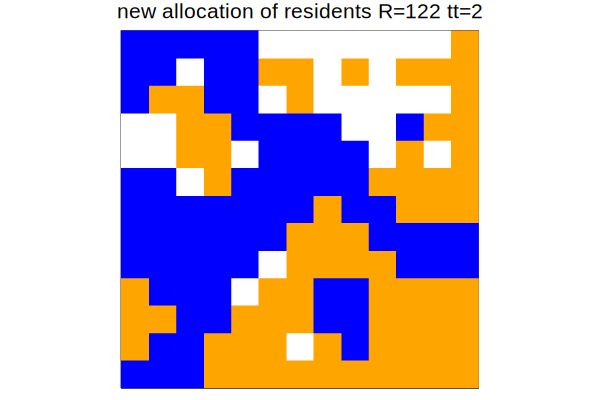

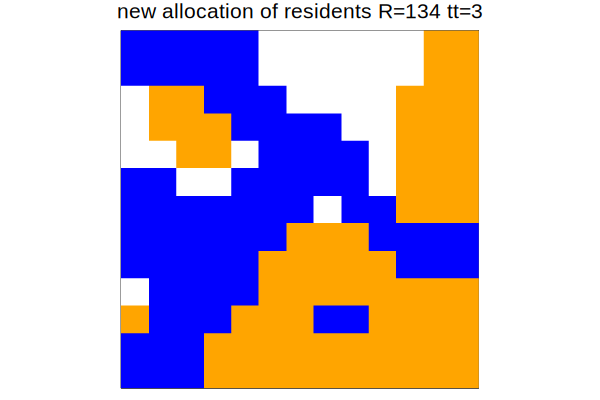

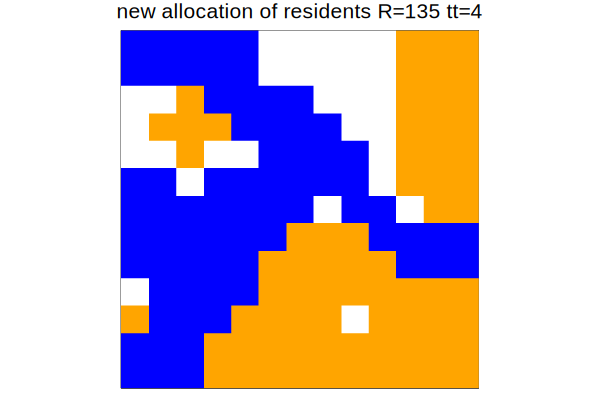

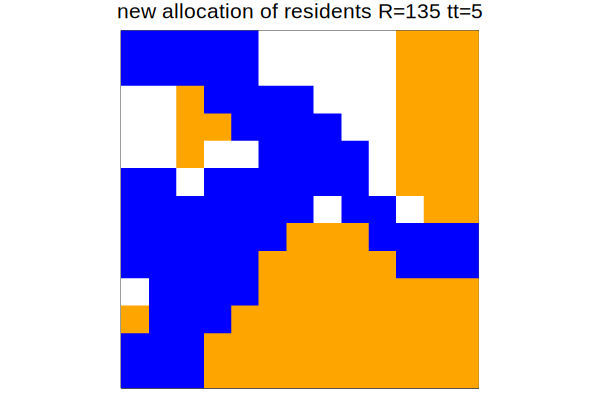

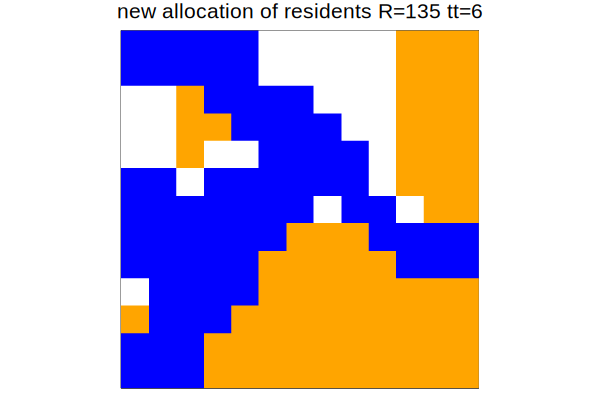

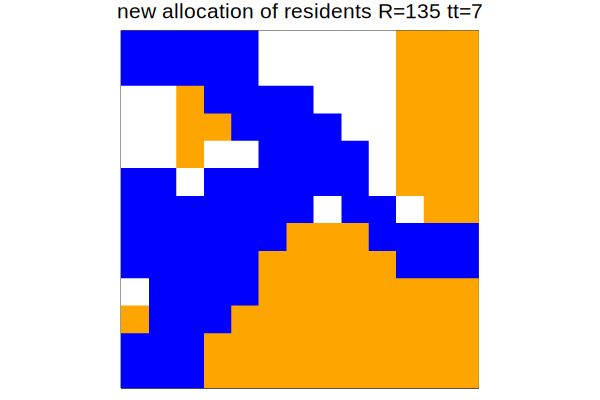

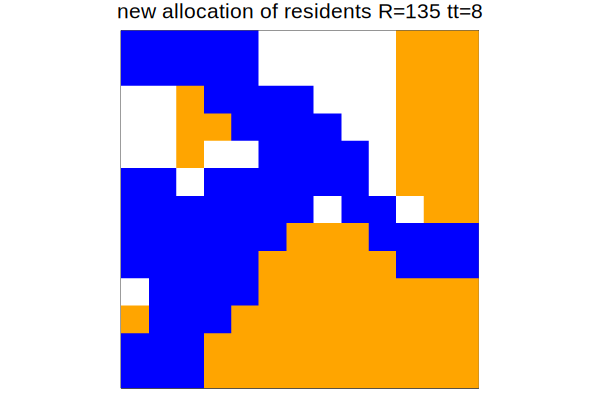

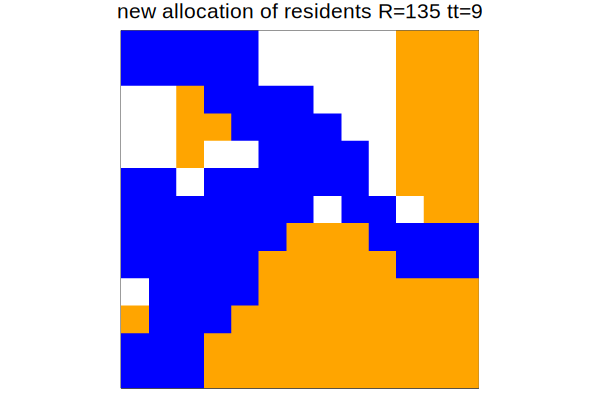

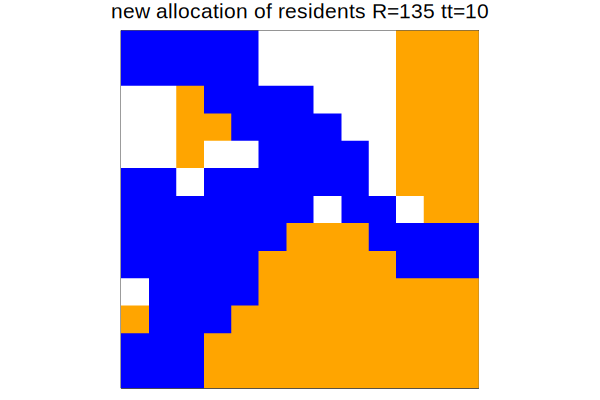

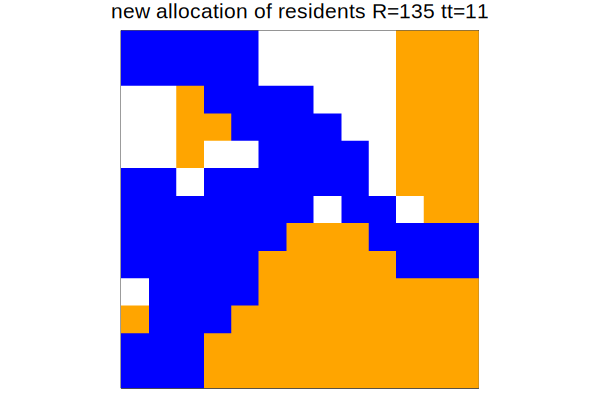

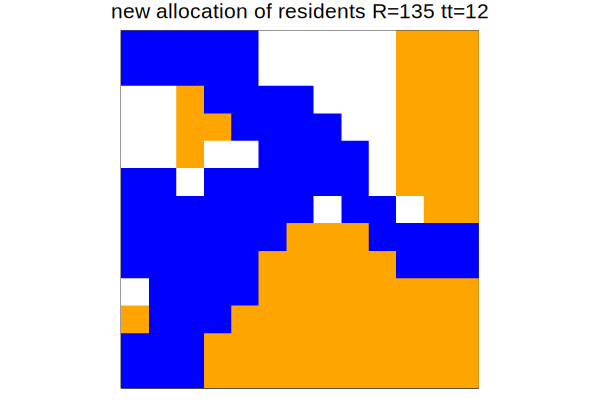

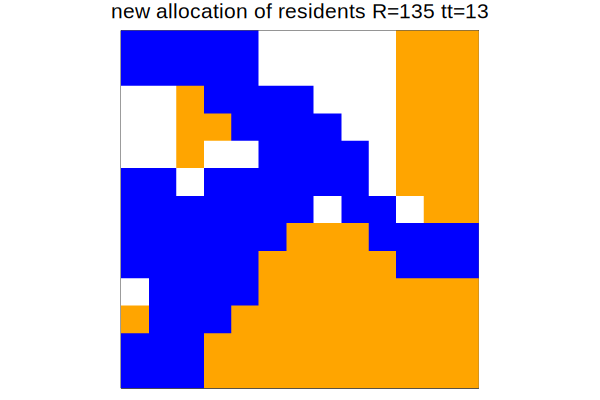

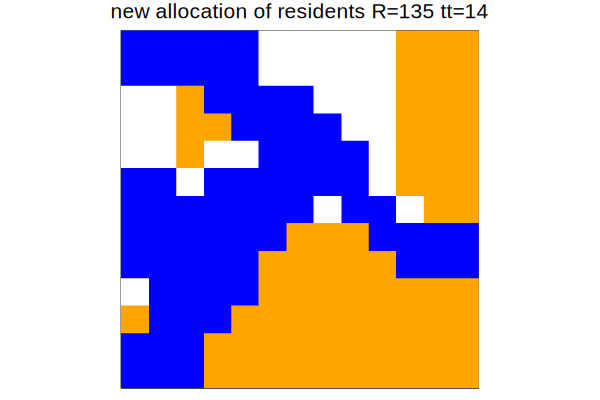

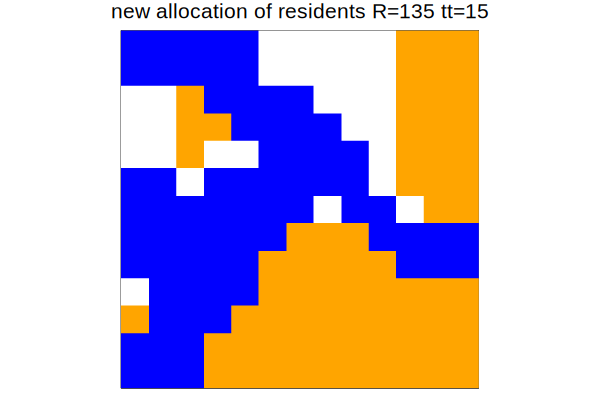

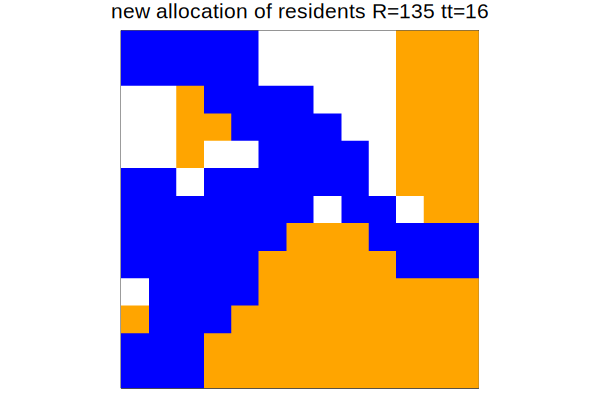

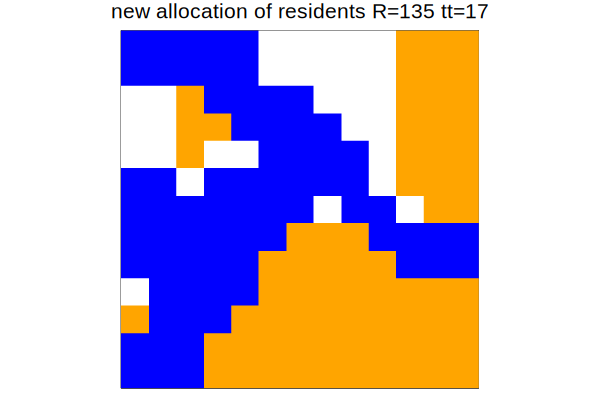

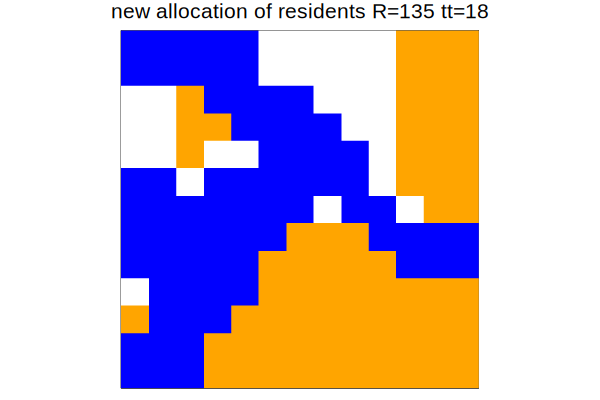

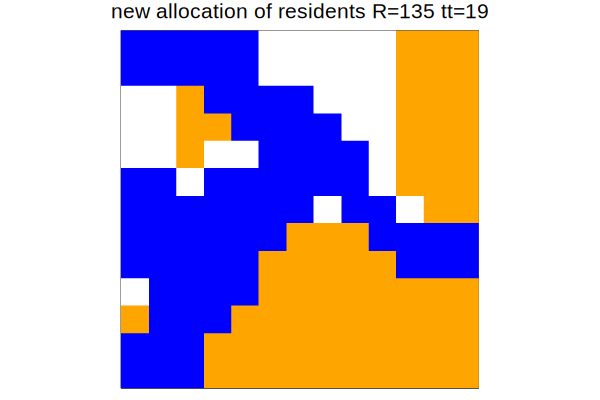

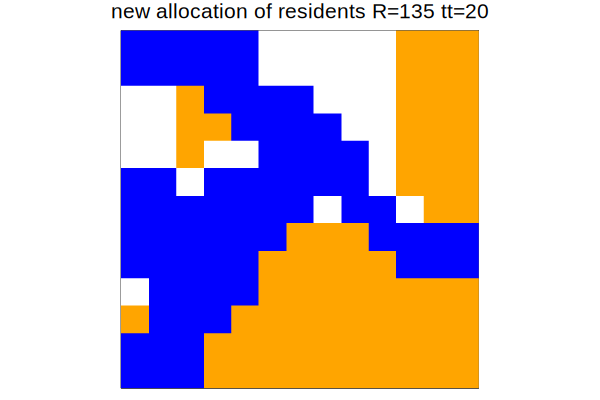

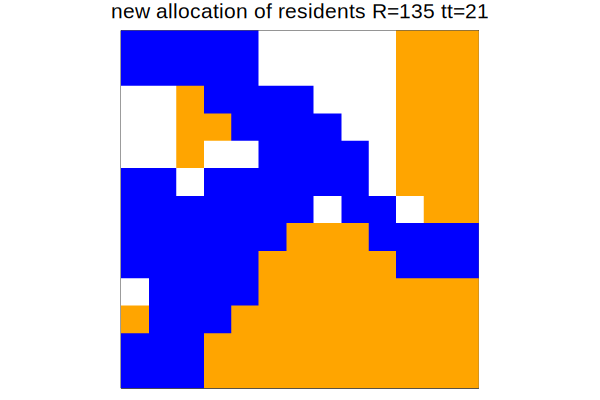

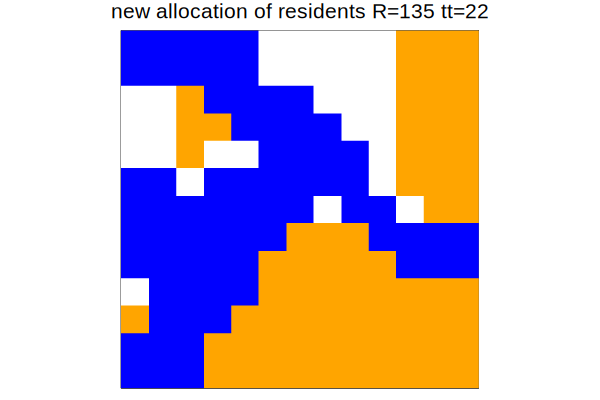

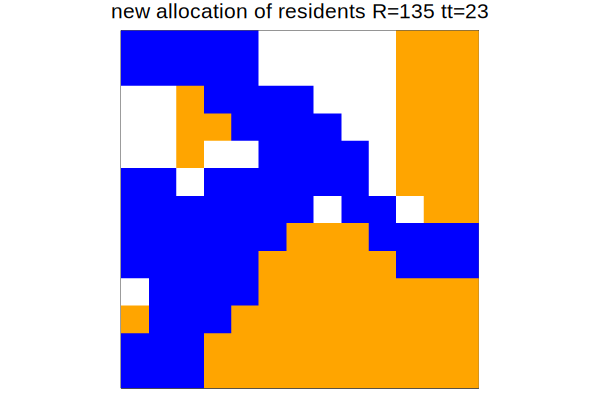

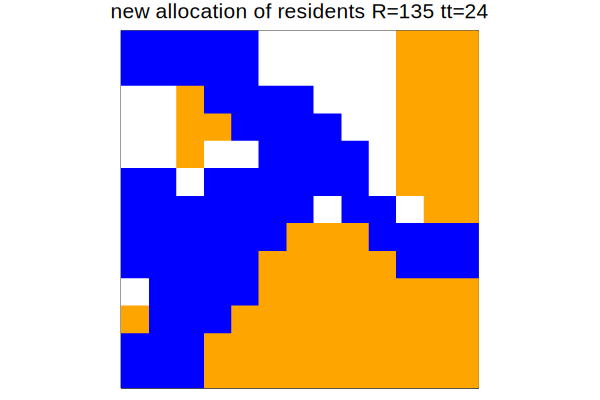

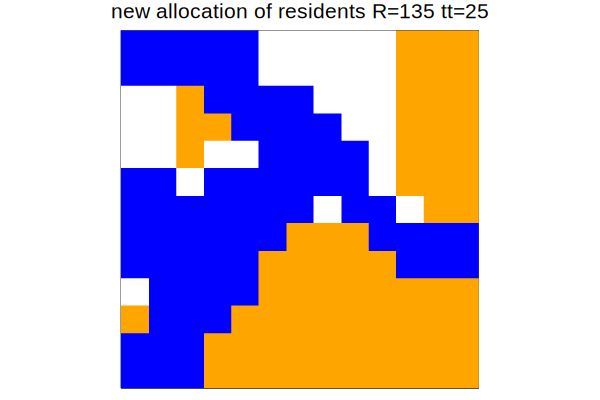

In [10]:
savefig(h3,"figs/newAllocation.png")


gridDict = Dict()
gridDict[1] = start_grid

for tt in 2:TT
gridDict[tt] = move_cells_for_satisfaction(gridDict[tt-1])
end
#println(gridDict)

hArray = []

for tt in 1:TT
    #println("tt=$tt")
    R = grid_satisfaction(gridDict[tt])
    hm = heatmap(gridDict[tt],title="new allocation of residents R=$(R) tt=$tt",
    showaxis=true,xticks=false,yticks=false,yaxis=:flip,aspect_ratio=1.0,framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=nothing,
    c=ColorGradient([:orange,:white,:blue]))
    display(hm)
    savefig(hm,"figs/simulationSnapShots1/time$(tt).png")
end



[52, 122, 134, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135]
Array{Int64,1}


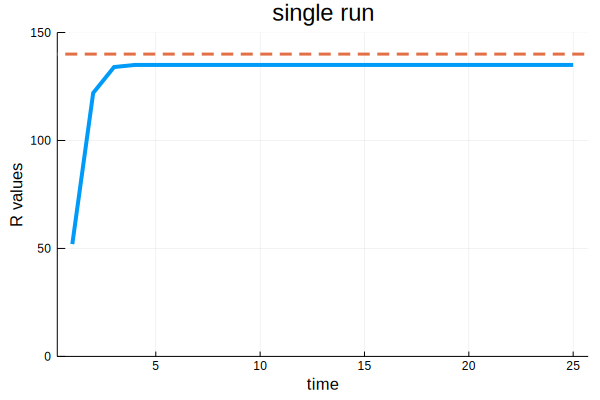

In [11]:

traceR = Int[]

for tt in 1:TT    
    append!(traceR,grid_satisfaction(gridDict[tt]))    
end
println(traceR)
println(typeof(traceR))
plt = plot(traceR,ylim=(0,R_MAX+10),leg=false,linewidth=4,titlefontsize=16,title="single run",xlabel="time",ylabel="R values")

#plot(traceR,ylim=(0,R_MAX+10),leg=false,guidefont=14,linewidth=4,xtickfontsize=10,ytickfontsize=10,titlefontsize=16,title="single run",xlabel="time",ylabel="R values")
hline!([R_MAX],line=(3,:dash),leg=false)

(25, 10)
[52.8; 125.2; 133.4; 135.0; 136.7; 137.2; 138.1; 138.1; 138.3; 138.3; 138.6; 138.6; 138.6; 138.6; 138.6; 138.6; 138.6; 138.6; 138.6; 138.6; 138.6; 138.6; 138.6; 138.6; 138.6]


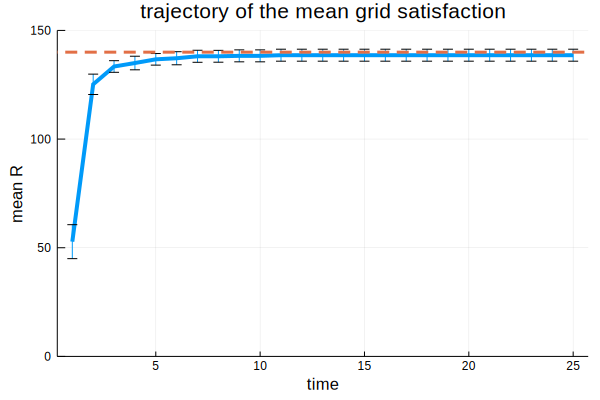

In [12]:
savefig(plt,"figs/singleRun.png")


simulationRvals = zeros(TT,MM)
for mm in 1:MM
    newGrid = shuffle(empty_grid)
    traceR = []
    append!(traceR,grid_satisfaction(newGrid))#initial time zero point
    for tt in 2:TT
        newGrid = move_cells_for_satisfaction(newGrid)
        append!(traceR,grid_satisfaction(newGrid))
    end
    simulationRvals[:,mm] = traceR[:]

end
    

println(size(simulationRvals))
println(mean(simulationRvals,dims=2))
plt = plot(mean(simulationRvals,dims=2),xlabel="time",ylabel="mean R",yerr=std(simulationRvals,dims=2),linewidth=4,ylim=(0,R_MAX+10),title="trajectory of the mean grid satisfaction") 
hline!([R_MAX],line=(3,:dash),leg=false)

In [13]:
savefig(plt,"figs/multipleRun.png")


println(simulationRvals[end,:])

[139.0, 140.0, 138.0, 139.0, 131.0, 140.0, 140.0, 139.0, 140.0, 140.0]


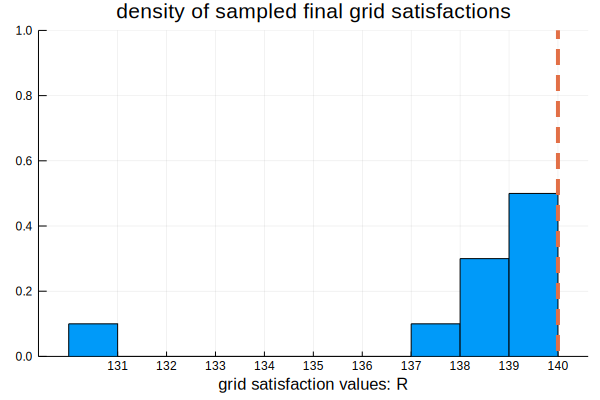

In [14]:
#get the histogram of the final values

pltHist = histogram(simulationRvals[end,:] .- 1,ylim=(0,1.0),xticks = (minimum(simulationRvals[end,:]):maximum(simulationRvals[end,:])) ,normalize=:probability,title="density of sampled final grid satisfactions",xlabel="grid satisfaction values: R",leg=false)#,xlim=(0,R_MAX+10)
vline!([R_MAX],line=(4,:dash),leg=false)



In [15]:
savefig(pltHist,"figs/finalHistRvals.png")


#sample random microstates
numberOfRandomSamples = 15000
randomSatisfactions = [grid_satisfaction(make_random_grid()) for x in 1:numberOfRandomSamples]

#set the macrostate count array to those random allocations 
sampleCountsR = [length(findall(randomSatisfactions .== R)) for R in 1:R_MAX]
#println(sampleCountsR)
replace!(sampleCountsR,0=>1)
#println(sampleCountsR)
sampleProbR = sampleCountsR ./ sum(sampleCountsR)
#println(sampleProbR)
#println(sum(sampleProbR))

#The cellspace for the macrostates is the multiple of the probability
sampleOmegaR = sampleProbR .* CELLS_SPACE_SIZE
#println(sampleOmegaR)


println(sampleOmegaR)
println(size(sampleOmegaR))

BigFloat[2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 2.23128e+69, 8.92512e+69, 6.69384e+69, 1.11564e+70, 8.92512e+69, 1.11564e+70, 4.68569e+70, 4.23943e+70, 6.91697e+70, 8.03261e+70, 1.27183e+71, 1.62883e+71, 2.27591e+71, 3.36923e+71, 3.77086e+71, 5.44432e+71, 5.71208e+71, 7.16241e+71, 8.65737e+71, 9.61682e+71, 1.1558e+72, 1.24952e+72, 1.32315e+72, 1.45926e+72, 1.55297e+72, 1.59537e+72, 1.71585e+72, 1.71362e+72, 1.74932e+72, 1.71139e+72, 1.55074e+72, 1.58867e+72, 1.42133e+72, 1.35662e+72, 1.2696e+72, 1.04424e+72, 9.17056e+71, 7.63098e+71, 6.42609e+71, 5.48895e+71, 4.61875e+71, 3.23536e+71, 3.05685e+71, 2.11972e+71, 1.71809e+71, 1.53958e+71, 8.92512e+70, 7.1401e+70, 5.3550

BigFloat[2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.22377e-21, 2.2198e-21, 2.22685e-21, 2.22377e-21, 2.22685e-21, 2.24667e-21, 2.24529e-21, 2.25204e-21, 2.25411e-21, 2.26045e-21, 2.26387e-21, 2.26849e-21, 2.2739e-21, 2.27546e-21, 2.28053e-21, 2.28119e-21, 2.28432e-21, 2.28693e-21, 2.28839e-21, 2.29092e-21, 2.292e-21, 2.29279e-21, 2.29414e-21, 2.295e-21, 2.29537e-21, 2.29638e-21, 2.29636e-21, 2.29665e-21, 2.29634e-21, 2.29498e-21, 2.29532e-21, 2.29378e-21, 2.29314e-21, 2.29222e-21, 2.28952e-21, 2.28773e-21, 2.28519e-21, 2.28282e-21, 2.28064e-21, 2.27826e-21, 2.27334e-21, 2.27256e-21, 2.26751e-21, 2.26461e-21, 2.26309e-21, 2.25556e-21, 2.25248e-21, 2.24851e-

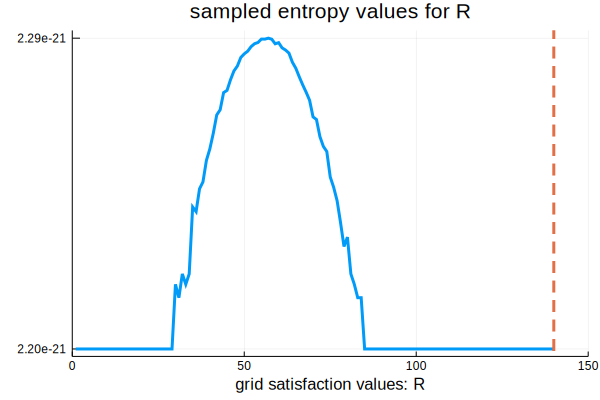

In [16]:
plt2 = plot(1:R_MAX,sampleOmegaR,xlim=(0,R_MAX+10),linewidth=3,title="sampled omega size for R",xlabel="grid satisfaction values: R")
vline!([R_MAX],line=(3,:dash),leg=false)
savefig(plt2,"figs/sampledOmega.png")



function S_entropy_values_from_R(R)
    return k_b * log(sampleOmegaR[R])
       
end

entropyVals = [S_entropy_values_from_R(R) for R in 1:R_MAX]

println(entropyVals)
println(S_entropy_values_from_R(1),"---",S_entropy_values_from_R(round(Int,R_MAX/2)))

minStr = string(minimum(entropyVals))[1:4] 
tmp = findfirst( isequal('e') , string(minimum(entropyVals)) )
tmp2 = string(minimum(entropyVals))[tmp:end]
labelMin = string(minStr,tmp2)
maxStr = string(maximum(entropyVals))[1:4] 
tmp = findfirst( isequal('e') , string(maximum(entropyVals)) )
tmp2 = string(maximum(entropyVals))[tmp:end]
labelMax = string(maxStr,tmp2)
println(labelMax,labelMin)

plt4 = plot(1:R_MAX,entropyVals,
    yticks=([minimum(entropyVals),maximum(entropyVals)],[labelMin,labelMax]),
    xlim=(0,R_MAX+10),ylim=(minimum(entropyVals)*(1-(10^-3)),(1 + 10^-3)*maximum(entropyVals)),
    linewidth=3,title="sampled entropy values for R",xlabel="grid satisfaction values: R")
vline!([R_MAX],line=(3,:dash),leg=false)

Any[59, 121, 124, 123, 124, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125]
Any[2.29498e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21]
-9.034845345667197030822218911005238002886203431572512496493064257682361786943901e-23
2.29e-212.20e-21


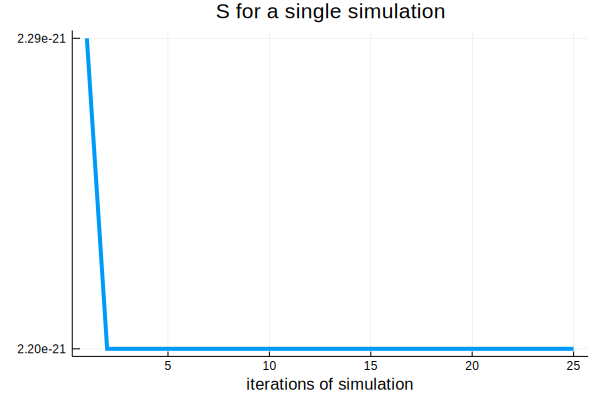

In [17]:
#plt3 = plot(1:R_MAX,entropyVals,xlim=(0,R_MAX+10),linewidth=3,title="sampled entropy values for R",xlabel="grid satisfaction values: R")
#vline!([R_MAX],line=(3,:dash),leg=false)
#savefig(plt3,"figs/sampledEntropy.png"
savefig(plt4,"figs/sampledEntropy.png")


#now do a single run trace with the entropy values and plot
traceR = Int[]
traceS = Int[]

newGrid = shuffle(empty_grid)
traceR = []
traceS = []
Rtmp = grid_satisfaction(newGrid)
append!(traceR,Rtmp)
append!(traceS,S_entropy_values_from_R(Rtmp))
for tt in 2:TT
    newGrid = move_cells_for_satisfaction(newGrid)
    Rtmp = grid_satisfaction(newGrid)
    append!(traceR,Rtmp)
    append!(traceS,S_entropy_values_from_R(Rtmp))
end
println(traceR)
println(traceS)

println( minimum(traceS) - maximum(traceS)   )


minStr = string(minimum(entropyVals))[1:4] 
tmp = findfirst( isequal('e') , string(minimum(entropyVals)) )
tmp2 = string(minimum(entropyVals))[tmp:end]
labelMin = string(minStr,tmp2)
maxStr = string(maximum(entropyVals))[1:4] 
tmp = findfirst( isequal('e') , string(maximum(entropyVals)) )
tmp2 = string(maximum(entropyVals))[tmp:end]
labelMax = string(maxStr,tmp2)
println(labelMax,labelMin)

plt5 = plot(traceS,yticks=([minimum(traceS),maximum(traceS)],[labelMin,labelMax]),ylims=(minimum(traceS)*(1-(10^-3)),(1 + 10^-3)*maximum(traceS)),
    linewidth=4,title="S for a single simulation",xlabel="iterations of simulation",leg=false)


In [18]:
savefig(plt5,"figs/entropySingleSimulation.png")



(25, 10)
2.29e-212.20e-21


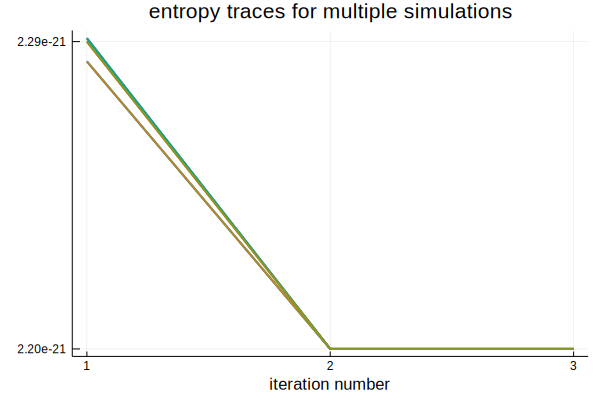

In [19]:


simulationSvals = zeros(TT,MM)
for mm in 1:MM
    traceR = Int[]
    traceS = Int[]

    newGrid = shuffle(empty_grid)
    traceR = []
    traceS = []
    Rtmp = grid_satisfaction(newGrid)
    append!(traceR,Rtmp)
    append!(traceS,S_entropy_values_from_R(Rtmp))
    for tt in 2:TT
        newGrid = move_cells_for_satisfaction(newGrid)
        Rtmp = grid_satisfaction(newGrid)
        append!(traceR,Rtmp)
        append!(traceS,S_entropy_values_from_R(Rtmp))
    end
    simulationSvals[:,mm] = traceS[:]

end

println(size(simulationSvals))
minimumS = minimum(simulationSvals)
maximumS = maximum(simulationSvals)



minStr = string(minimum(simulationSvals))[1:4] 
tmp = findfirst( isequal('e') , string(minimum(simulationSvals)) )
tmp2 = string(minimum(simulationSvals))[tmp:end]
labelMin = string(minStr,tmp2)
maxStr = string(maximum(simulationSvals))[1:4] 
tmp = findfirst( isequal('e') , string(maximum(simulationSvals)) )
tmp2 = string(maximum(simulationSvals))[tmp:end]
labelMax = string(maxStr,tmp2)
println(labelMax,labelMin)

plt7 = plot(simulationSvals[1:3,1:end],
    yticks=([minimum(traceS),maximum(traceS)],[labelMin,labelMax]),
    ylims=(minimum(simulationSvals)*(1-(10^-3)),(1 + 10^-3)*maximum(simulationSvals)),
    xticks=1:3,
    linewidth=2,xlabel="iteration number",title="entropy traces for multiple simulations",leg=false)#,ylim=(0,R_MAX+10)) 


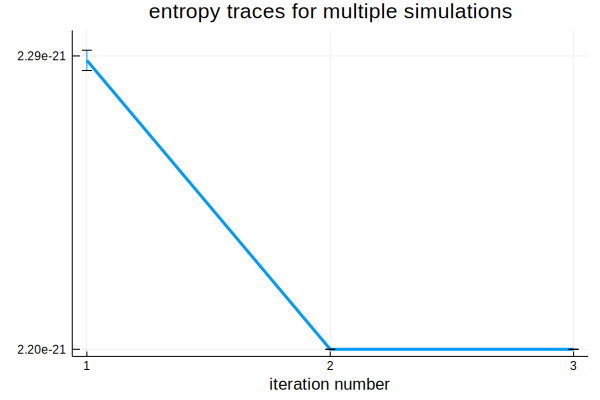

In [20]:
savefig(plt7,"figs/entropyMultipleSimulations.png")


plt8 = plot(mean(simulationSvals,dims=2)[1:3],
    yerr=std(simulationSvals,dims=2)[1:3],
    yticks=([minimum(traceS),maximum(traceS)],[labelMin,labelMax]),
    ylims=(minimum(simulationSvals)*(1-(10^-3)),(1 + 3*10^-3)*maximum(simulationSvals)),
    xticks=1:3,
    linewidth=3,xlabel="iteration number",title="entropy traces for multiple simulations",leg=false)#,ylim=(0,R_MAX+10)) 



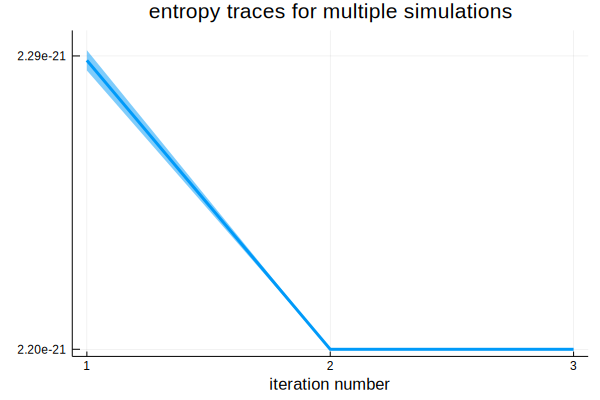

In [21]:
savefig(plt8,"figs/entropyMultipleSimulationsSpread.png")


plt9 = plot(mean(simulationSvals,dims=2)[1:3],
    ribbon=std(simulationSvals,dims=2)[1:3],
    yticks=([minimum(traceS),maximum(traceS)],[labelMin,labelMax]),
    ylims=(minimum(simulationSvals)*(1-(10^-3)),(1 + 3*10^-3)*maximum(simulationSvals)),
    xticks=1:3,
    linewidth=3,xlabel="iteration number",title="entropy traces for multiple simulations",leg=false)#,ylim=(0,R_MAX+10)) 


In [22]:
savefig(plt9,"figs/entropyMultipleSimulationsSpreadRibbon.png")




In [23]:
##################
#FINANCE PART NOW!
##################


#wealth distribution data taken from: https://raw.githubusercontent.com/jkeesh/which-percent/master/data.csv
# It is based on data from the US census as well as the Social Security Administration
csvWealth = CSV.File("wealthDistribution.csv",header=false)
dfWealth = DataFrame(csvWealth)
percs = dfWealth[:,4]
percsNew=[percs[i][1:end-1] for i in 1:length(percs)]
percsNewNew = [ parse(Float64,percsNew[i]) for i in 1:length(percs)]


function df2wealthArray(dfWealth)
    meansBracket = []
    for i in 1:size(dfWealth)[1]
        
        inds = findall(isequal(' '),dfWealth[i,1])
        
        money1 = dfWealth[i,1][1:inds[1]-1]
        money2 = dfWealth[i,1][inds[2]+1:end]
        
        
        
        if(i == size(dfWealth)[1])
            money2 = money1
        end
        
        money1 = replace(money1,","=>"")
        money2 = replace(money2,","=>"")
        money1 = parse(Float64,money1)
        money2 = parse(Float64,money2)
        
        #println(mean([money1,money2]))
        append!(meansBracket,mean([money1,money2]))
        
    end
    return meansBracket
end
wealthBrackets = df2wealthArray(dfWealth)
percsAndWealth = hcat(percsNewNew,wealthBrackets) 
println(percsAndWealth)
println(percsAndWealth[1,:])


Any[100.0 2500.0; 85.7293 7499.99; 76.9745 12500.0; 69.1804 17500.0; 61.9069 22500.0; 55.0045 27500.0; 48.561 32500.0; 42.5631 37500.0; 37.1403 42500.0; 32.3649 47500.0; 28.2287 52500.0; 24.6107 57500.0; 21.5469 62500.0; 18.891 67500.0; 16.632 72500.0; 14.6756 77500.0; 12.9786 82500.0; 11.5263 87500.0; 10.2775 92500.0; 9.1938 97500.0; 8.254 102500.0; 7.4264 107500.0; 6.7202 112500.0; 6.1026 117500.0; 5.5552 122500.0; 5.0663 127500.0; 4.6402 132500.0; 4.2636 137500.0; 3.9302 142500.0; 3.635 147500.0; 3.3701 152500.0; 3.127 157500.0; 2.915 162500.0; 2.7278 167500.0; 2.5601 172500.0; 2.4087 177500.0; 2.272 182500.0; 2.1452 187500.0; 2.032 192500.0; 1.9275 197500.0; 1.8301 225000.0; 1.1727 275000.0; 0.8155 325000.0; 0.6046 375000.0; 0.4656 425000.0; 0.37 475000.0; 0.3012 750000.0; 0.0825 1.25e6; 0.0411 1.75e6; 0.0258 2.25e6; 0.0182 2.75e6; 0.0138 3.25e6; 0.0108 3.75e6; 0.0087 4.25e6; 0.0072 4.75e6; 0.0061 7.5e6; 0.002 1.5e7; 0.0006 3.5e7; 0.0001 5.0e7]
Any[100.0, 2500.0]


In [24]:
#now sample according to the population a wealth bracket

function wealthBracketSample()
    brackets = findall(isequal(true), rand()*100 .<= percsAndWealth[:,1] )
    maxBracketInd = maximum(brackets)
    #println(maxBracketInd)
    return percsAndWealth[maxBracketInd,2]
end

wealthSamples = [wealthBracketSample() for i in 1:10]
println(wealthSamples)


[92500.0, 22500.0, 47500.0, 32500.0, 52500.0, 27500.0, 82500.0, 17500.0, 47500.0, 37500.0]


--yellow mean--40928.57142857143--blue mean--44642.857142857145
std yellow sample 69617.44771905326
std blue sample 41121.69486803621
skewness yellow sample 4.003313233506809
skewness blue sample 1.2312018187261666


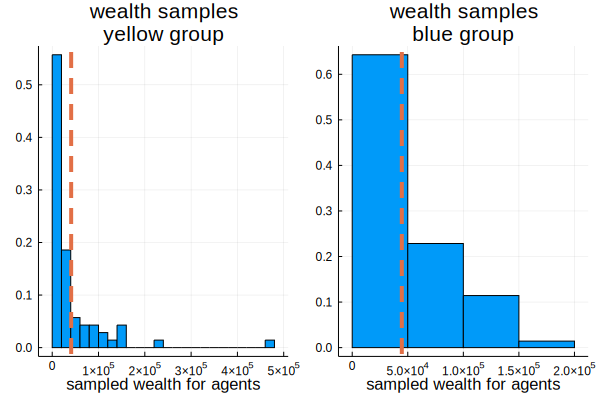

In [25]:

wealthSamplesYellow = [wealthBracketSample() for i in 1:yellow_count]
wealthSamplesYellow = round.(wealthSamplesYellow)
wealthSamplesBlue = [wealthBracketSample() for i in 1:blue_count]
wealthSamplesBlue = round.(wealthSamplesBlue)

println("--yellow mean--",mean(wealthSamplesYellow),"--blue mean--",mean(wealthSamplesBlue))

println("std yellow sample $(std(wealthSamplesYellow))")
println("std blue sample $(std(wealthSamplesBlue))")
println("skewness yellow sample $(skewness(wealthSamplesYellow))")
println("skewness blue sample $(skewness(wealthSamplesBlue))")

pltHistYellow = histogram(wealthSamplesYellow,normalize=:probability,title="wealth samples \n yellow group",xlabel="sampled wealth for agents",leg=false)#,xlim=(0,R_MAX+10)
vline!([mean(wealthSamplesYellow)],line=(4,:dash),leg=false)

pltHistBlue = histogram(wealthSamplesBlue,normalize=:probability,title="wealth samples \n blue group",xlabel="sampled wealth for agents",leg=false)#,xlim=(0,R_MAX+10)
vline!([mean(wealthSamplesBlue)],line=(4,:dash),leg=false)

plt2hist = plot(pltHistYellow,pltHistBlue)

[2500.0, 2500.0, 2500.0, 7500.0, 2500.0, 37500.0, 12500.0, 2500.0, 2500.0, 225000.0, 2500.0, 2500.0, 7500.0, 152500.0, 22500.0, 17500.0, 17500.0, 7500.0, 2500.0, 2500.0, 2500.0, 12500.0, 17500.0, 77500.0, 117500.0, 2500.0, 17500.0, 47500.0, 2500.0, 12500.0, 132500.0, 7500.0, 22500.0, 17500.0, 32500.0, 27500.0, 17500.0, 42500.0, 7500.0, 82500.0, 27500.0, 2500.0, 2500.0, 72500.0, 7500.0, 27500.0, 7500.0, 87500.0, 12500.0, 27500.0, 57500.0, 32500.0, 475000.0, 92500.0, 32500.0, 7500.0, 12500.0, 47500.0, 12500.0, 7500.0, 27500.0, 62500.0, 7500.0, 7500.0, 152500.0, 147500.0, 117500.0, 27500.0, 22500.0, 7500.0, 62500.0, 17500.0, 72500.0, 12500.0, 72500.0, 32500.0, 37500.0, 2500.0, 42500.0, 132500.0, 192500.0, 57500.0, 12500.0, 77500.0, 22500.0, 77500.0, 7500.0, 2500.0, 27500.0, 17500.0, 77500.0, 52500.0, 17500.0, 37500.0, 37500.0, 17500.0, 82500.0, 72500.0, 52500.0, 112500.0, 12500.0, 37500.0, 2500.0, 127500.0, 22500.0, 57500.0, 2500.0, 37500.0, 42500.0, 2500.0, 27500.0, 62500.0, 2500.0, 1750

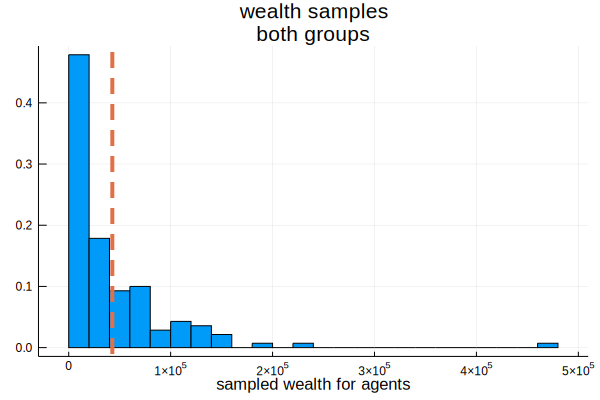

In [26]:

savefig(plt2hist,"figs/histwealthYellow.png")

totalWealthSamples = [wealthSamplesYellow ; wealthSamplesBlue]
println(totalWealthSamples)
println(size(totalWealthSamples))

pltHistTotal = histogram(totalWealthSamples,normalize=:probability,title="wealth samples \n both groups",xlabel="sampled wealth for agents",leg=false)#,xlim=(0,R_MAX+10)
vline!([mean(totalWealthSamples)],line=(4,:dash),leg=false)


--yellowNormed mean--0.014285714285714284--blueNormed mean--0.014285714285714285
std yellowNormed sample 0.024299283671571817
std blueNormed sample 0.013158942357771588
skewness yellowNormed sample 4.003313233506812
skewness blueNormed sample 1.23120181872617


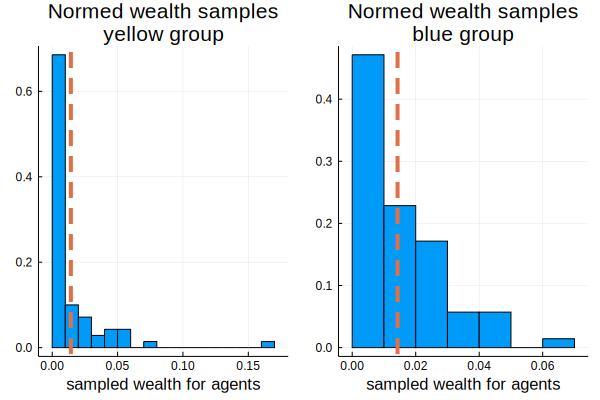

In [27]:

savefig(pltHistTotal,"figs/histwealthTotal.png")

wealthSamplesYellowNormed = wealthSamplesYellow ./ sum(wealthSamplesYellow)
wealthSamplesBlueNormed = wealthSamplesBlue ./ sum(wealthSamplesBlue)

println("--yellowNormed mean--",mean(wealthSamplesYellowNormed),"--blueNormed mean--",mean(wealthSamplesBlueNormed))

println("std yellowNormed sample $(std(wealthSamplesYellowNormed))")
println("std blueNormed sample $(std(wealthSamplesBlueNormed))")
println("skewness yellowNormed sample $(skewness(wealthSamplesYellowNormed))")
println("skewness blueNormed sample $(skewness(wealthSamplesBlueNormed))")

pltHistYellowNormed = histogram(wealthSamplesYellowNormed,normalize=:probability,title="Normed wealth samples \n yellow group",xlabel="sampled wealth for agents",leg=false)#,xlim=(0,R_MAX+10)
vline!([mean(wealthSamplesYellowNormed)],line=(4,:dash),leg=false)

pltHistBlueNormed = histogram(wealthSamplesBlueNormed,normalize=:probability,title="Normed wealth samples \n blue group",xlabel="sampled wealth for agents",leg=false)#,xlim=(0,R_MAX+10)
vline!([mean(wealthSamplesBlueNormed)],line=(4,:dash),leg=false)

plotNormedHists = plot(pltHistYellowNormed,pltHistBlueNormed)


In [28]:
savefig(plotNormedHists,"figs/histwealthYellow.png")


In [29]:
#in the finance grid we store both the type of agent and the financial part
function make_random_finance_grid()    
    empty_grid = zeros(GRID_SIZE,GRID_SIZE,2)
    shiftsTmp = GRID_SIZE^2;
    #set the agent occupations in the lattice
    empty_grid[1:yellow_count] .= 1
    empty_grid[yellow_count+1:yellow_count+blue_count] .= -1
    #set the financial values for the agents
    empty_grid[1+shiftsTmp:yellow_count+shiftsTmp] .= wealthSamplesYellowNormed
    empty_grid[yellow_count+1+shiftsTmp:yellow_count+blue_count+shiftsTmp] .= wealthSamplesBlueNormed
    
    empty_grid[:,:,1] = shuffle(empty_grid[:,:,1])
    empty_grid[:,:,2] = shuffle(empty_grid[:,:,2])
    return empty_grid
end

moneyGrid = make_random_finance_grid()
println(moneyGrid)
println(sum(moneyGrid))

[-1.0 -1.0 1.0 0.0 -1.0 -1.0 1.0 1.0 -1.0 -1.0 -1.0 0.0 -1.0; 1.0 -1.0 -1.0 -1.0 -1.0 1.0 1.0 -1.0 1.0 1.0 -1.0 -1.0 0.0; -1.0 -1.0 1.0 1.0 0.0 -1.0 -1.0 0.0 -1.0 0.0 -1.0 -1.0 -1.0; 1.0 1.0 1.0 -1.0 -1.0 0.0 -1.0 1.0 1.0 -1.0 1.0 -1.0 1.0; 1.0 -1.0 1.0 1.0 0.0 -1.0 1.0 1.0 -1.0 1.0 1.0 -1.0 1.0; 0.0 1.0 -1.0 1.0 1.0 1.0 -1.0 1.0 -1.0 1.0 1.0 1.0 -1.0; 1.0 1.0 1.0 -1.0 1.0 1.0 -1.0 0.0 -1.0 -1.0 0.0 -1.0 -1.0; 1.0 1.0 -1.0 1.0 1.0 0.0 -1.0 1.0 -1.0 1.0 0.0 1.0 1.0; 1.0 1.0 1.0 0.0 1.0 1.0 -1.0 1.0 1.0 0.0 -1.0 -1.0 1.0; 1.0 0.0 1.0 1.0 -1.0 -1.0 -1.0 0.0 -1.0 -1.0 1.0 0.0 -1.0; -1.0 -1.0 0.0 0.0 -1.0 1.0 0.0 -1.0 -1.0 0.0 0.0 0.0 1.0; -1.0 -1.0 1.0 1.0 1.0 0.0 0.0 1.0 -1.0 1.0 -1.0 1.0 -1.0; -1.0 -1.0 -1.0 -1.0 1.0 -1.0 1.0 1.0 1.0 0.0 0.0 0.0 -1.0]

[0.0 0.0008726 0.0424 0.0095986 0.0008 0.036 0.0152 0.0008726 0.0026178 0.0095986 0.165794 0.0008726 0.0168; 0.0264 0.0248 0.0026178 0.0200698 0.0532286 0.0008726 0.078534 0.0008726 0.0113438 0.0072 0.021815 0.0410122 0.004363; 0.0 0.0008 

In [30]:
#get the financial surroundings
function cell_surround_arrayTMP_financial(gridFull,row,col)
    grid = gridFull[:,:,2]
    cell_surrounding = []
    for ii in 0:2
        for jj in 0:2
            if(!(  (ii==1 && jj==1) || (row-1+(ii) < 1) ||  (col-1+(jj) < 1) || (row-1+(ii) > GRID_SIZE) || (col-1+(jj) > GRID_SIZE)   ))
                append!(cell_surrounding,grid[row-1+(ii),(col-1)+(jj)])
            end

        end
    end

    return cell_surrounding
end
arrayCellFinance = cell_surround_arrayTMP_financial(moneyGrid,11,12)
println(arrayCellFinance)

Any[0.0008726, 0.0095986, 0.0, 0.0287958, 0.0056, 0.0270506, 0.0424, 0.0184]


In [31]:

#the equivalent of 'thresholdFN' that examines a locality to see financial deviation
function financial_cell_deviation(gridFull,cellSurroundArray,row,col)
    cellFinance = gridFull[row,col,2]
    if(cellFinance == 0)
        return 0
    end
    #println(cellFinance)    
    deviation = mad(cellSurroundArray,center=cellFinance,normalize=false)
    return deviation
    
end

moneyDeviation = financial_cell_deviation(moneyGrid,arrayCellFinance,11,12)
println(moneyDeviation)
println(moneyGrid[11,12,2])


0
0.0


In [32]:
#find the total deviation for the cells finances
function financial_grid_deviation(gridFull)
    #grid = gridFull[:,:,2]
    cell_deviation = []

    for row in 1:GRID_SIZE
        for col in 1:GRID_SIZE
            arrayCellFinance = cell_surround_arrayTMP_financial(gridFull,row,col)
            #t=cell_surround_arrayTMP(grid,row,col)  #R2 = R_grid(start_grid)
            moneyDeviation = financial_cell_deviation(gridFull,arrayCellFinance,row,col)
            #tmpBinary = thresholdFN(t,grid[row,col],row,col)
            append!(cell_deviation,moneyDeviation)
        end
    end    
    return sum(cell_deviation)    
    
end
gridDeviationMedians = financial_grid_deviation(moneyGrid);
println(gridDeviationMedians)
println("yay")


1.9614666666666667
yay


mean of the deviations for the sampled= 1.91483379930192


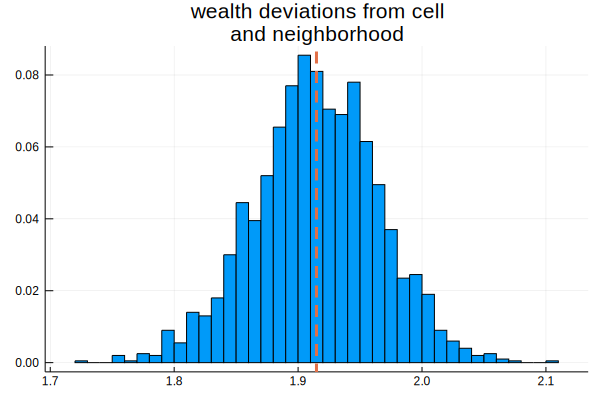

In [42]:
#try running the random deviations over a set to see the distribution
numberOfRandomSamples = 2000
randomMoneyDeviations = [ financial_grid_deviation(make_random_finance_grid()) for x in 1:numberOfRandomSamples]
#println(randomMoneyDeviations)
meanRealSampleMoneyDeviations = mean(randomMoneyDeviations)

println("mean of the deviations for the sampled= $(mean(randomMoneyDeviations))")
pltHist = histogram(randomMoneyDeviations,leg=false,normalize=:probability,title="wealth deviations from cell\n and neighborhood")
vline!([mean(randomMoneyDeviations)],line=(3,:dash),leg=false)



2.000000000000001
mean of the deviations for he uniform sampled= 1.307465897565983


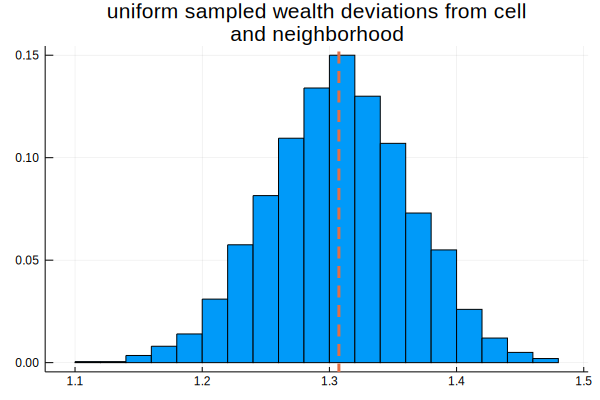

In [43]:
savefig(plotNormedHists,"figs/histwealthSampleDeviations.png")


#in the finance grid we store both the type of agent and the financial part
yellowUniformSample = rand(yellow_count)
blueUniformSample = rand(blue_count)
wealthSamplesYellowUniformSampled = yellowUniformSample ./ sum(yellowUniformSample)
wealthSamplesBlueUniformSampled = blueUniformSample ./ sum(blueUniformSample)
function make_uniform_sampled_finance_grid()    
    empty_grid = zeros(GRID_SIZE,GRID_SIZE,2)
    shiftsTmp = GRID_SIZE^2;
    
    #set the agent occupations in the lattice
    empty_grid[1:yellow_count] .= 1
    empty_grid[yellow_count+1:yellow_count+blue_count] .= -1
    #set the financial values for the agents
    empty_grid[1+shiftsTmp:yellow_count+shiftsTmp] .= wealthSamplesYellowUniformSampled
    empty_grid[yellow_count+1+shiftsTmp:yellow_count+blue_count+shiftsTmp] .= wealthSamplesBlueUniformSampled
    
    empty_grid[:,:,1] = shuffle(empty_grid[:,:,1])
    empty_grid[:,:,2] = shuffle(empty_grid[:,:,2])
    return empty_grid
end

moneyGridUniformSampled = make_uniform_sampled_finance_grid()
println(sum(moneyGridUniformSampled))


randomUniformMoneyDeviations = [ financial_grid_deviation(make_uniform_sampled_finance_grid()) for x in 1:numberOfRandomSamples]
#println(randomMoneyDeviations)
meanRealUniformMoneyDeviations = mean(randomUniformMoneyDeviations)

println("mean of the deviations for he uniform sampled= $(mean(randomUniformMoneyDeviations))")
pltHist = histogram(randomUniformMoneyDeviations,leg=false,normalize=:probability,title="uniform sampled wealth deviations from cell\n and neighborhood")
vline!([mean(randomUniformMoneyDeviations)],line=(3,:dash),leg=false)


In [35]:
savefig(plotNormedHists,"figs/histwealthUniformSampleDeviations.png")


#do the same histograms again but with the squared deviation this time
#see if the squared deviation and the mean are better


##just make a function to move the agents around and see if the deviation is altered
#take the trace over time and since thre is no dynamics move one cell randomly at a time 
#but they do still radiate their money randomly and uniformly upon their destination locality
#where they end up, plot hlines for the means of the the two histograms above
#look at the results for starting with the uniform and real data to see if the deviation goes up or down...
#then do the randoml movement but people only move into areas where they have more than the median of
#the locality. and on arrival disperse radially a random percentage of their wealth around them.
#check the median and mean deviations for th grid overt that time and check to see if it locks as
#if there is a point where the movement stops. 
function move_cells_for_wealth_NoDynamics(grid)
    
    newGrid = deepcopy(grid)
    nonZeroCells = findall(grid .!= 0)
    nonZeroCells2 = shuffle(nonZeroCells)
    satisfiedNonZeroCells = [is_cell_satisfied(newGrid,nzc[1],nzc[2]) for nzc in nonZeroCells2]    
    #R_START = grid_satisfaction(grid)

    #remove (skip) the satisfied, don't include them in the rotation on each iteration
    satisfiedInds = findall(satisfiedNonZeroCells .== 1)
    deleteat!(nonZeroCells2,satisfiedInds)   
    
    for nzc in nonZeroCells2        
        isCellSatisfied = is_cell_satisfied(newGrid,nzc[1],nzc[2])
        
        if(isCellSatisfied != 1)          
            emptyCells = findall(newGrid .== 0)
            emptyCells2 = shuffle(emptyCells)
            #find an empty cell nzc could move to
            moved = false
            for ec in emptyCells2                
                wouldCellBeSatisfied = would_cell_be_satisfied(newGrid,ec[1],ec[2],newGrid[nzc[1],nzc[2]] )
                if(wouldCellBeSatisfied == 1)  
                    
                    newGrid[ec[1],ec[2]] = newGrid[nzc[1],nzc[2]]
                    newGrid[nzc[1],nzc[2]] = 0  
                    #no longer try to move it
                    moved = true
                    break
                end                
            end   
            #=if(moved == false)
                println("cell at i=$(nzc[1]) and j=$(nzc[2]) did not move")
            end=#
        end       
    end
    
    return newGrid
end

newGrid = move_cells_for_satisfaction(start_grid)

satisfiedOneGrid = grid_satisfaction(newGrid)




In [36]:
#schelling said that the small changes in probability can have drastic effects. and that these
#preferencces can be so small that even the agents themselves the residents are not 
#aware of their biases because of the effects on the macrostate examining individuals
#may not be a viable solution. Therefore examining the macrostate and the change in the
#entropy would be a more sensitive and reslient approach. the minor amplificiations on
#the agent level can produce massive combinational changes on the macrostate.
#it also reacts quickly!

#the radial disperal at the start is benign, but afterwards the high wealth individuals
#create a block for the low to now enter like in physics for the satisfaction of new
#molecular bonds in how satisfied they will be. That is the same as 'gentrification'
 
#we get wealth samples, and sample from that for the allocations and then the wealth on movement 
#that here is initially random that gets radially distributed.
#how many random allocations of the financial units would it take to arrive at the 
#distribution of the wealth indicators
#eg, we start out with wealth sampled from the CDF, we allocate them to the residents. 
#they then move around randomly without homogeneity search
#we then do a set of random allocations of the funds to get a distribution for the variance 
#of the wealth and the skew so that we can say that the macro state variable is the variance and skew

#later we do the model that has both the homogeneity and the financial indicators and get the macrostate trajectory

#question: we need to have the purchasing to be constrained so that they cannot move forever 
#or that we can regulated it according to the size of the system.
#if tons of wealth is dropped it can go forever? or can we say that the wealth 
#movement is a relative measure? the relative measure would be more robust but the constrained version
#should also work.

In [37]:
#now to find a model that respects an increasing entropy value trace
#now to do the financial part...


#when an agent moves into a new place, they subtract the averagej from themselves
#and distribute that radially amongst the surrounding people.

#what is the accumulated gaps (disparity) ....of the wealth on the local levels..! :)
#take the min and max due to corners, then we keep that difference, and take the accumulation 
#of the total differences
#we simply compare that aggregate to the aggregates of the random initial samples...



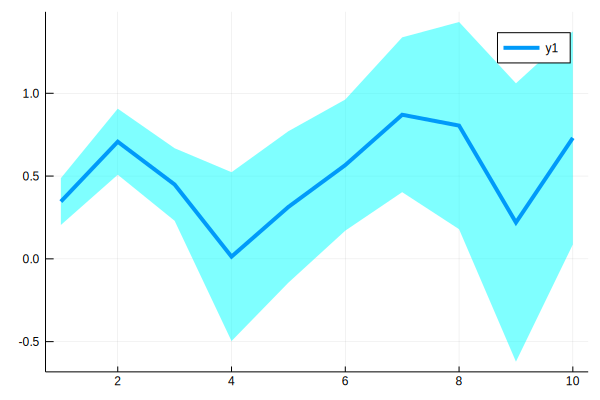

In [38]:
 plot(rand(10),ribbon=rand(10),fill=:cyan,linewidth=4)

In [39]:
function f1(x)
    x = x^2
    return x+x
end

f1 (generic function with 1 method)

In [40]:
x=3
println(f1(x))

18


$$\lambda + \beta$$
$$\frac{12}{4}$$

In [41]:
#old code


function grid_satisfactionOLD(start_grid) 
cell_satisfaction = []

    for row in 1:GRID_SIZE
        for col in 1:GRID_SIZE
            cell_surrounding = []
            if(!(row == 1 || row == GRID_SIZE || col == 1 || col == GRID_SIZE))#general inner body
                for ii in 0:2
                    for jj in 0:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if((row==GRID_SIZE && col==GRID_SIZE))#bottom right corner
                for ii in 0:1
                    for jj in 0:1
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if((row==1 && col==1))#top left corner
                for ii in 1:2
                    for jj in 1:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if((row==1 && col==GRID_SIZE))#top right corner
                for ii in 1:2
                    for jj in 0:1
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if((row==GRID_SIZE && col==1))#bottom left corner
                for ii in 0:1
                    for jj in 1:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if((row==1 && (col < GRID_SIZE && col > 1) ))#top edge
                for ii in 1:2
                    for jj in 0:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if( (row > 1 && row < GRID_SIZE) && (col == 1) )#left edge
                for ii in 0:2
                    for jj in 1:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)

                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end

            end
            if( (row > 1 && row < GRID_SIZE) && (col == GRID_SIZE) )#right edge
                for ii in 0:2
                    for jj in 0:1
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)

                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end

            end
            if( (row == GRID_SIZE) && (col > 1 && col < GRID_SIZE) )#bottom edge
                for ii in 0:1
                    for jj in 0:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)

                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end

            end
        end
    end
#println(cell_satisfaction)
#println(size(cell_satisfaction))
#println(sum(cell_satisfaction))

    return sum(cell_satisfaction)
end

satisfiedOneGrid = grid_satisfactionOLD(start_grid)
println("random grid satisfactionOLD value=",satisfiedOneGrid)
R_MAX = grid_satisfactionOLD(set_grid)
println("set grid satisfactionOLD value=",R_MAX)

random grid satisfactionOLD value=85
set grid satisfactionOLD value=140
